In [ ]:
pip install mlxtend

# Feature Importances for PA classifier

In this notebook, we discuss feature importances for PA classification. We will perfom drop feature and permuation importance. By an analysis of feature importances, we conclude that random forest is the best model for roc auc score, compared to logistic regression, support vector classifier, decision tree, AdaBoost, and voting classifier.

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns
#import dataframe_image as dfi
#import upsetplot

sns.set_theme(style='whitegrid')

# import utils for loading data
# see `load_tables` in utils.py
import utils

## Drop-Feature Importance

Given a set of features $F$, a model $M$, dataset $D$, and a scoring function $s$, we define for each feature $f \in F$ its drop-feature importance as
$$DFI(f) = s(M(F, D)) - s(M(F', D)),$$
where $F' = F\backslash \{f\}$ is the subset of $F$ removing $f$, and $M(F, D)$ is the model $M$ on feature set $F$ trained on dataset $D$.

From the formula, $DFI(f)$ depends on the feature set $F$, the model $M$, dataset $D$ and also the scoring function $s$.

We have evaluated a list of models on all possible feature subsets in the [PA classification notebook](./pa_classifier.ipynb). We can use it to compute the drop-feature importance.

In [2]:
model_eval_path = os.path.join(utils.DATA_FOLDER, 'model_evals.csv')
df_evals = pd.read_csv(model_eval_path)

# make sense of fid
num_cols = ['correct_diagnosis', 'tried_and_failed', 'contraindication', 'random']
cat_cols = ['bin', 'drug']
all_cols = cat_cols + num_cols

subsets = []
for fid in range(2 ** len(all_cols)):
    fid_bin = [(fid >> i) & 1 for i in range(len(all_cols))]
    subsets.append(fid_bin)

df_features = pd.DataFrame(
    data=subsets, columns=all_cols
).reset_index().rename(columns={'index': 'fid'})

df_evals = pd.merge(df_evals, df_features, on='fid', how='left')

df_evals.sample(5, random_state=614)

,fid,model,data_type,score_func,score,bin,drug,correct_diagnosis,tried_and_failed,contraindication,random
3649,41,Decision Tree,validation,precision,0.749495,1,0,0,1,0,1
5340,60,SVC,train,accuracy,0.739523,0,0,1,1,1,1
6444,51,Bayes,test,roc_auc,0.500000,1,1,0,0,1,1
5244,59,Logistic,train,f1,0.832639,1,1,0,1,1,1
6496,55,Bayes,train,precision,1.000000,1,1,1,0,1,1


Reading the table above, take the 4th row as an example, it says the f1 score of the logistic regression on the training data is 0.832639, when trained using feature set [`bin`, `drug`,`tried_and_failed`, `contraindication`, `random`]. All models are always trained on the train data.

In [3]:
def drop_feature_importance(
    models, data_type='validation',
    score_func='roc_auc', include_random=True):
    '''Compute importance of a feature by dropping it.
    
    The baseline model use all available features. Then the importance of the
    feature X is computed by the difference of the score between the baseline model
    and the model without the feature X.
    '''
    if type(models) is str:
        models = [models]
    models = list(models)
    if 'Baseline' in models:
        models.remove('Baseline')
    fil = df_evals.model.isin(models) & (df_evals.data_type == data_type)
    fil = fil & (df_evals.score_func == score_func)
    df = df_evals[fil]
    
    n_col = len(all_cols)
    if not include_random:
        n_col -= 1
    
    fid_all = (1 << n_col) - 1
    feat_mask = [fid_all ^ (1 << i) for i in range(n_col)]
    
    data = []
    for model in models:
        baseline = df[(df.fid == fid_all) & (df.model == model)].score.tolist()[0]
        imp = []
        for mask in feat_mask:
            s = df[(df.fid == mask) & (df.model == model)].score.tolist()[0]
            imp.append(baseline - s)
        data.append(imp)
    df = pd.DataFrame(data=data, columns=all_cols[:n_col], index=models)
    
    return df

Let's take a look at the feature importances by accuracy.

In [4]:
drop_feature_importance(
    df_evals.model.unique(),
    score_func='accuracy',
    include_random=False
)

,bin,drug,correct_diagnosis,tried_and_failed,contraindication
Logistic,0.005239,-0.002721,0.019179,-0.018752,0.039257
SVC,0.005711,-0.002248,-0.004812,0.006565,0.039842
Decision Tree,0.071207,0.062056,-0.000922,0.005531,0.032130
Random Forest,0.071207,0.062056,-0.000922,0.005531,0.032130
Voting,0.053197,0.045238,-0.005733,-0.008814,0.037436
AdaBoost,-0.012703,-0.022596,0.000719,0.002046,0.019381
Bayes,0.071207,0.062056,-0.000922,0.005531,0.032130


Decision tree and random forest give the same feature importances in this classification problem. When we use decision tree model, the most importance feature for accuracy is `bin`, and the least important one is `correct_diagnosis`. In fact, removing `correct_diagnosis` will improve the model performace on accuracy.

Using different scoring function will give different importances. Next, we will look at feature importances based on roc auc score.

In [5]:
model = 'Decision Tree'
scoring = 'roc_auc'
df_drop_imp = drop_feature_importance(
    model,
    score_func=scoring,
    include_random=False
)

df_drop_imp

,bin,drug,correct_diagnosis,tried_and_failed,contraindication
Decision Tree,0.16983,0.137612,-0.014918,-0.026949,-0.03761


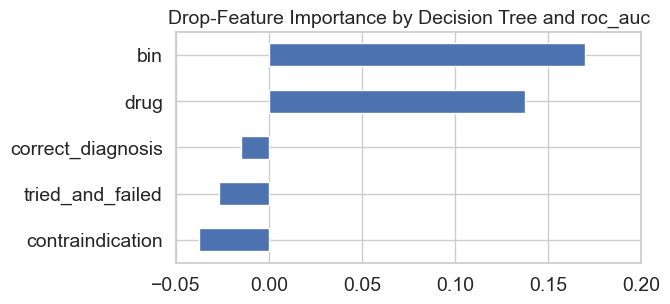

In [6]:
plt.figure(figsize=(6, 3))
df_drop_imp.loc[model, :].sort_values().plot(kind='barh', fontsize=14)
plt.title(f'Drop-Feature Importance by {model} and {scoring}', fontsize=14)
plt.xlim([-0.05, 0.20])
plt.show()

It shows a very different result than that using accuracy. We need to stress that **the feature importance only compare importances within a given feature set using a particular model and scoring function**. In this plot, we should say that to the decision tree model on the 5 features in the y-axis, the most important feature is `bin` if we care about roc auc score. The three features `correct_diagnosis`, `tried_and_failed` and `contraindication` actually decrease the roc auc score. Removing any of them will improve the model on the roc auc score, and removing `contraindication` improve the model the most.

In practice, we will include a random feature. The random feature then serves as a pivot feature for comparison. It will give us a better set of feature importances.

In [7]:
model = 'Decision Tree'
scoring = 'roc_auc'
df_drop_imp2 = drop_feature_importance(
    model,
    score_func=scoring,
    include_random=True
)

df_drop_imp2

,bin,drug,correct_diagnosis,tried_and_failed,contraindication,random
Decision Tree,0.146273,0.134037,0.004171,0.013742,0.033976,-0.019893


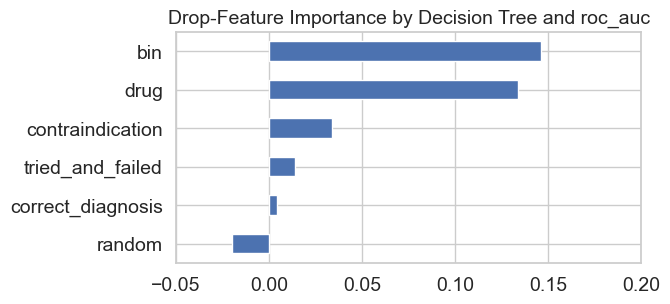

In [8]:
plt.figure(figsize=(6, 3))
df_drop_imp2.loc[model, :].sort_values().plot(kind='barh', fontsize=14)
plt.title(f'Drop-Feature Importance by {model} and {scoring}', fontsize=14)
plt.xlim([-0.05, 0.20])
plt.show()

Inclding the pivot feature `random` changes feature importances a lot, since the feature set is now different. `bin` and `drug` are still the two most important features, having large impact on the roc auc score. The three features `correct_diagnosis`, `tried_and_failed` and `contraindication` now positively impact on the score, which make more sense. Moreover, we can see `contraindication` is the third most important feature. This confirms our intuition, since `contraindication` indicates the treatment could do harm to patients.

Looking at the importances of features, we can also justify whether a model is good or not. If we care about roc auc score, decision tree is a good model, in a sense that it captures all important features such as `bin`, `drug` and `contraindication`.

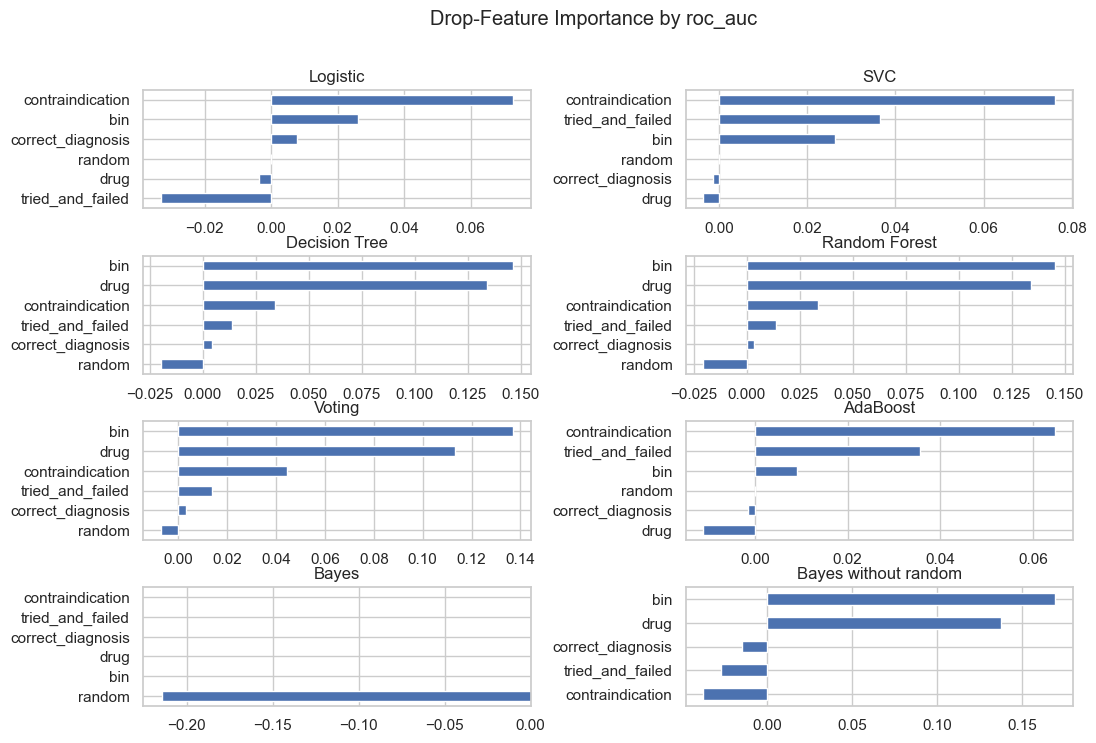

In [9]:
scoring = 'roc_auc'
models = df_evals.model.unique().tolist()
models.remove('Baseline')
df_drop_imp_all = drop_feature_importance(
    models,
    score_func=scoring,
    include_random=True
)

fig, axes = plt.subplots(4, 2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
axes = axes.flatten()
for model, ax in zip(models, axes):
    df_drop_imp_all.loc[model, :].sort_values().plot(kind='barh', ax=ax)
    ax.set_title(f'{model}')
fig.suptitle(f'Drop-Feature Importance by {scoring}')

model = 'Bayes'
scoring = 'roc_auc'
df_drop_imp3 = drop_feature_importance(
    model,
    score_func=scoring,
    include_random=False
)
df_drop_imp3.loc[model, :].sort_values().plot(kind='barh', ax=axes[-1])
axes[-1].set_title('Bayes without random')

plt.show()

According to feature importances, we see that decision tree, random forest and voting classifier are good models to make sense of roc auc scores. On the contrary, we conclude that logistic regression, support vector classifier (SVC) and AdaBoost are not good if we are interested in high roc auc scores, because they fail to capture importance features.

The Bayes optimal predictor is tricky. It can identify the `random` feature, but fails to compare feature importances with the `random` feature present. We plot feature importances for the Bayes optimal predictor without the `random` feature in the lower right corner. Just like the decision tree model, it decides that `contraindication` actually lowers the model's performance on roc auc score.

Among the good models, voting classifier is not as good as decision tree and random forest, in a way that its random feature has higher importance. To compare decision tree and random forest, we will look at confidence intervals of their feature importances.

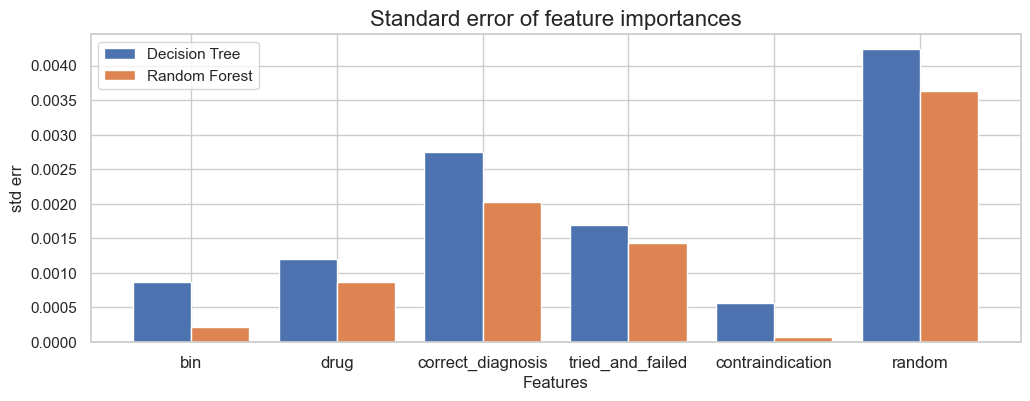

In [10]:
data_types = ['validation', 'test']
models = ['Decision Tree', 'Random Forest']
scoring = 'roc_auc'

df_drop_imp_ci = pd.concat([
    drop_feature_importance(
        models,
        data_type=dt,
        score_func=scoring,
        include_random=True,
    ) for dt in data_types
], axis=0)

x_axis = np.arange(df_drop_imp_ci.shape[1])
padding = 0.2
width = 2 * padding

plt.figure(figsize=(12, 4))
plt.bar(x_axis - padding, df_drop_imp_ci.loc['Decision Tree'].std(), width, label='Decision Tree')
plt.bar(x_axis + padding, df_drop_imp_ci.loc['Random Forest'].std(), width, label='Random Forest')

plt.xticks(x_axis, df_drop_imp_ci.columns, fontsize=12)
plt.xlabel('Features')
plt.ylabel('std err', fontsize=12)
plt.title('Standard error of feature importances', fontsize=16)

plt.legend()
plt.show()

Since standard errors are small compared to means of feature importances, it is hard to visualize the confidence intervals. However, the mean for each feature importance are close for decision tree and random forest, so we can just compare their standard errors. Standard errors are better if smaller.

Random forest has smaller standard errors for all features, so it is better than decision tree. However, keep in mind that the standard error for each importance is calculated by only two samples. We conclude that **random forest is the best model from this analysis of drop-feature importances, if we use roc auc as our scoring function**.

## Permutation Importance
The permutation importance of a feature is defined to be the decrease in a model score when the feature column is permuted and the metric is evaluated again. This procedure breaks the relationship between the feature and the response variable and so a drop in model performance indicates how much the model depends on this feature. This is especially useful for non-linear estimators. 

We will use the F score as our metric. The reason is that we consider False Negatives and False Positives to be critical and the F score encapsulates this better than accuracy. Recall that 
$$ F = 2\bigg(\frac{\text{precision}\cdot \text{recall}}{\text{precision} + \text{recall}}\bigg). $$

First we load the data, clean it, and use one-hot encoding to turn all of the categorical features into binary features. 

In [11]:
# Load Data
df_date=pd.read_csv("data/dim_date.csv")
df_claim=pd.read_csv("data/dim_claims.csv")
df_pa=pd.read_csv("data/dim_pa.csv")
df_bridge=pd.read_csv("data/bridge.csv")

# Clean data so all reject_code values are integers
df_claim['reject_code'] = df_claim.reject_code.fillna(0).astype(int)

# Merge the data frames
df_main = pd.merge(df_claim, df_bridge, on='dim_claim_id')
df_main = pd.merge(df_main, df_pa, how='left', on='dim_pa_id')
df_main = pd.merge(df_main, df_date, how='left', on='dim_date_id')

# split the data frames into two -- PA requested or not
df_main_wPA = df_main[~np.isnan(df_main.pa_approved)].copy()
df_main_noPA = df_main[np.isnan(df_main.pa_approved)].copy()

# encode all categorical features in the case that a PA was requested 
df_aug=df_main_wPA.copy()
df_aug['70'] = pd.get_dummies(df_aug['reject_code'])[70]
df_aug['75'] = pd.get_dummies(df_aug['reject_code'])[75]
df_aug['76'] = pd.get_dummies(df_aug['reject_code'])[76]
df_aug['bin417380']=pd.get_dummies(df_aug['bin'])[417380]
df_aug['bin999001']=pd.get_dummies(df_aug['bin'])[999001]
df_aug['bin417740']=pd.get_dummies(df_aug['bin'])[417740]
df_aug['bin417614']=pd.get_dummies(df_aug['bin'])[417614]
df_aug['drug_A']=pd.get_dummies(df_aug['drug'])['A']
df_aug['drug_B']=pd.get_dummies(df_aug['drug'])['B']
df_aug['drug_C']=pd.get_dummies(df_aug['drug'])['C']

Now we make the train-test split. We use $20$% of the data as the test set. 

In [12]:
from sklearn.model_selection import train_test_split

feats=['70', '75', 'bin417380','bin417740', 'bin417614','correct_diagnosis', 'contraindication', 'tried_and_failed', 'drug_A', 'drug_B']

X=df_aug[feats]
y=df_aug[['pa_approved']]

X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                test_size=.2,
                                                shuffle=True,
                                                stratify=y)

X_train=np.array(X_train)
X_test = np.array(X_test)
y_train=np.array(y_train).ravel()
y_test =  np.array(y_test).ravel()


Now we import the necessary model classes.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

class GroupAverageClassifier(BaseEstimator, TransformerMixin, ClassifierMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        self.approved_count_ = Counter()
        self.total_count_ = Counter()
        for r, t in zip(X, y):
            g = tuple(r)
            self.approved_count_[g] += t
            self.total_count_[g] += 1
        return self
    
    def transform(self, X, y=None):
        return self.predict_proba(X)
    
    def predict(self, X):
        prob = self.predict_prob(X)
        pred = (prob > 0.5).astype(int)
        return pred
    
    def predict_prob(self, X):
        prob = np.zeros(X.shape[0])
        eps = 1e-4
        for i, r in enumerate(X):
            g = tuple(r)
            prob[i] = self.approved_count_[g] / (self.total_count_[g] + eps)
        return prob

def get_func_name(f):
    name = f.__name__
    if name.endswith('_score'):
        name = name[:-6]
    return name

Now we decide the scores we use to measure the quality of our models and write the function to evaluate all of the models. 

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, balanced_accuracy_score

default_scores = [accuracy_score, precision_score, recall_score,f1_score, roc_auc_score, balanced_accuracy_score]
default_names = [get_func_name(f) for f in default_scores]

models = {}

DATASETS = [(X_train, y_train), (X_test, y_test)]

def evaluate(model, name, decimal=4, score_funcs=default_scores):
    model.fit(X_train, y_train)
    scores = np.empty((2, len(score_funcs)))
    for i, (X, y) in enumerate(DATASETS):
        yhat = model.predict(X_train)
        for j, func in enumerate(score_funcs):
            scores[i, j] = func(y_train, yhat)
    scores = scores.round(decimal)
    func_names = [get_func_name(f) for f in score_funcs]
    df = pd.DataFrame(data=scores, columns=func_names, index=['train', 'test'])
    
    models[name] = (model, df)

Now we evaluate all of the models using the above function.

In [17]:
lrc = LogisticRegression(penalty='l2', C=1)
evaluate(lrc, 'Logistic')

In [18]:
bayes_clf=GroupAverageClassifier()
evaluate(bayes_clf, 'Bayes')

In [19]:
rfc = RandomForestClassifier()
evaluate(rfc, 'Random Forest')

In [20]:
svc = LinearSVC(penalty='l2', C = 1)
evaluate(svc, 'SVC')

In [21]:
dt_clf = DecisionTreeClassifier()
evaluate(dt_clf, 'Decision Tree')

In [23]:
voting_clf = VotingClassifier(
                [('lr',lrc),
                 ('dt', dt_clf),
                ('rf',rfc),
                ('svm',svc),
                ('gp',bayes_clf)])
evaluate(voting_clf, 'Voting')

In [24]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
            n_estimators = 10,
            algorithm="SAMME.R",
            learning_rate = 0.5)
evaluate(ada_clf, 'AdaBoost')

Now we can perform the permutation importance test. We save the mean importance scores and the standard deviations of those scores. 

In [25]:
from sklearn.inspection import permutation_importance

importances = []
model_names = []
std_devs=[]
for name, (mdl, _) in models.items():
    model_names.append(name)
    r = permutation_importance(mdl, X_train, y_train, n_repeats=50,random_state=42, scoring='f1')
    importances.append(r['importances_mean'])
    std_devs.append(r['importances_std'])
df_importances = pd.DataFrame(data=importances,columns=feats,index=model_names)
df_std_devs=pd.DataFrame(data=std_devs,columns=feats,index=model_names)
df_sall=pd.DataFrame(data=all,columns=feats,index=model_names)

The mean permutation importance scores are given below. The shade of the cell corresponds to how high the score is. 

In [26]:
cm = sns.light_palette("green", as_cmap=True)
df_importances.style.background_gradient(cmap=cm, axis=1)

,70,75,bin417380,bin417740,bin417614,correct_diagnosis,contraindication,tried_and_failed,drug_A,drug_B
Logistic,0.041395,0.012941,0.001333,0.009570,0.005408,0.000489,0.034290,0.009802,0.043056,0.009740
Bayes,0.261856,0.294641,0.187723,0.124299,0.260360,0.000714,0.031773,0.008823,0.241084,0.192636
Random Forest,0.039566,0.006642,0.004361,0.000048,0.001591,0.000714,0.031773,0.008823,0.011170,0.001195
SVC,0.040432,0.006322,-0.001079,0.005677,0.003959,0.000556,0.031636,0.005977,0.040166,0.006275
Decision Tree,0.098022,0.000290,0.000000,0.000464,0.019578,0.000714,0.031773,0.008823,0.002184,0.001784
Voting,0.046755,0.007725,0.000409,0.004697,0.004333,0.000714,0.031773,0.008823,0.040430,0.005689
AdaBoost,0.034987,0.007121,0.000000,-0.000818,0.000000,0.000000,0.025630,0.003802,0.008502,0.000000


We can look at the standard deviations as well. The standard deviations are small relative to the permutation scores, which is a good thing since it indicates there is less variability between the different runs of the test. 

In [27]:
df_std_devs

,70,75,bin417380,bin417740,bin417614,correct_diagnosis,contraindication,tried_and_failed,drug_A,drug_B
Logistic,0.000216,0.000151,0.000070,0.000193,0.000140,0.000072,0.000228,0.000186,0.000270,0.000140
Bayes,0.000715,0.000748,0.000479,0.000389,0.000722,0.000073,0.000233,0.000173,0.000695,0.000555
Random Forest,0.000200,0.000134,0.000145,0.000025,0.000081,0.000073,0.000233,0.000173,0.000164,0.000059
SVC,0.000252,0.000148,0.000095,0.000170,0.000123,0.000084,0.000224,0.000156,0.000274,0.000168
Decision Tree,0.000329,0.000030,0.000000,0.000036,0.000228,0.000073,0.000233,0.000173,0.000056,0.000078
Voting,0.000229,0.000142,0.000057,0.000147,0.000117,0.000073,0.000233,0.000173,0.000247,0.000105
AdaBoost,0.000212,0.000156,0.000000,0.000155,0.000000,0.000000,0.000214,0.000118,0.000169,0.000000


From the above table, we can construct a list of all the features in order of descending importance for each model. 

We would like to plot the mean importance scores as well as the standard deviations, but before we do so, it is important to note that the sets of features:
\begin{align*} & \big\{ \text{ 'drug_A', drug_B' } \big\} \\
& \big\{ \text{ 'bin417380', 'bin417740', 'bin417614' }\big\} \\
& \big\{\text{ '70', '75' }\big\}
\end{align*}
are highly correlated. 

This is because the payer, drug, and reject code were all categorical variables that were one-hot encoded as binary features. In highly correlated features, permuting one feature will have a smaller effect on the models performance since the model can get corresponding information from the correlated feature. We can handle this by performing hierarchical clustering. 

In [28]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

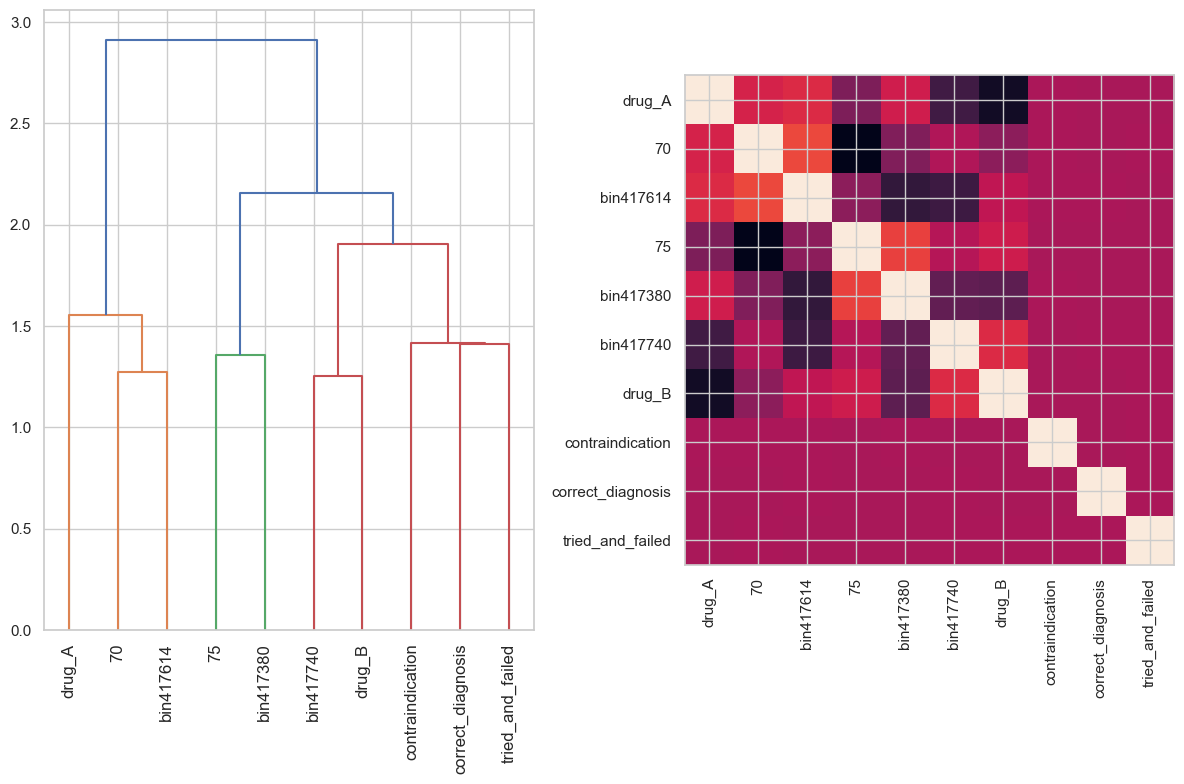

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr_linkage=hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=X.columns.tolist(), ax=ax1, leaf_rotation=90
)

dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

We will keep the features from the red cluster and repeat the procedure for permuation importance. 

In [30]:
heir_feats=['bin417740','correct_diagnosis', 'contraindication', 'tried_and_failed', 'drug_B']

X=df_aug[heir_feats]
y=df_aug[['pa_approved']]

X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                test_size=.2,
                                                shuffle=True,
                                                stratify=y)
models={}
X_train=np.array(X_train)
X_test = np.array(X_test)
y_train=np.array(y_train).ravel()
y_test = np.array(y_test).ravel()

DATASETS = [(X_train, y_train), (X_test, y_test)]

We again evaluate each model individually, but this time the features are those in the red cluster in the above plot. 

In [31]:
lrc = LogisticRegression(penalty='l2', C=1)
evaluate(lrc, 'Logistic')

In [32]:
bayes_clf=GroupAverageClassifier()
evaluate(bayes_clf, 'Bayes')

In [33]:
rfc = RandomForestClassifier()
evaluate(rfc, 'Random Forest')

In [34]:
svc = LinearSVC(penalty='l2')
evaluate(svc, 'SVC')

In [35]:
dt_clf = DecisionTreeClassifier()
evaluate(dt_clf, 'Decision Tree')

In [36]:
voting_clf = VotingClassifier(
                [('lr',lrc),
                 ('dt', dt_clf),
                ('rf',rfc),
                ('svm',svc),
                ('gp',bayes_clf)])
evaluate(voting_clf, 'Voting')

In [37]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
            n_estimators = 10,
            algorithm="SAMME.R",
            learning_rate = 0.5)
evaluate(ada_clf, 'AdaBoost')

In [38]:
from sklearn.inspection import permutation_importance

heir_importances = []
model_names = []
heir_std_devs=[]
for name, (mdl, _) in models.items():
    model_names.append(name)
    r = permutation_importance(mdl, X_train, y_train, n_repeats=50,random_state=42, scoring='f1')
    heir_importances.append(r['importances_mean'])
    heir_std_devs.append(r['importances_std'])
heir_df_importances = pd.DataFrame(data=heir_importances,columns=heir_feats,index=model_names)
heir_df_std_devs=pd.DataFrame(data=heir_std_devs,columns=heir_feats,index=model_names)
heir_df_sall=pd.DataFrame(data=all,columns=heir_feats,index=model_names)

Now we have the mean importance scores and standard deviations from $50$ shuffles of each feature column. We can see that the standard deviations are all relatively small, which is good. However, we see that some of the importance scores are negative for drug_B, meaning some models actually performed better with this feature data randomized. 

In [39]:
heir_df_std_devs

,bin417740,correct_diagnosis,contraindication,tried_and_failed,drug_B
Logistic,0.000129,0.000031,0.000271,0.000135,0.000137
Bayes,0.000158,0.000047,0.000227,0.000175,0.000175
Random Forest,0.000158,0.000047,0.000227,0.000175,0.000175
SVC,0.000144,0.000091,0.000176,0.000095,0.000077
Decision Tree,0.000158,0.000047,0.000227,0.000175,0.000175
Voting,0.000158,0.000047,0.000227,0.000175,0.000175
AdaBoost,0.000144,0.000000,0.000143,0.000059,0.000053


In [40]:
cm = sns.light_palette("green", as_cmap=True)
heir_df_importances.style.background_gradient(cmap=cm, axis=1)

,bin417740,correct_diagnosis,contraindication,tried_and_failed,drug_B
Logistic,0.005303,0.000091,0.025502,0.005342,0.003653
Bayes,0.023379,0.000174,0.020549,0.010143,0.021220
Random Forest,0.023379,0.000174,0.020549,0.010143,0.021220
SVC,0.004451,0.000510,0.012455,0.001422,-0.001233
Decision Tree,0.023379,0.000174,0.020549,0.010143,0.021220
Voting,0.023379,0.000174,0.020549,0.010143,0.021220
AdaBoost,0.003357,0.000000,0.008740,0.000660,-0.003080


We plot the means and standard deviations of the models in order to better understand the data. 

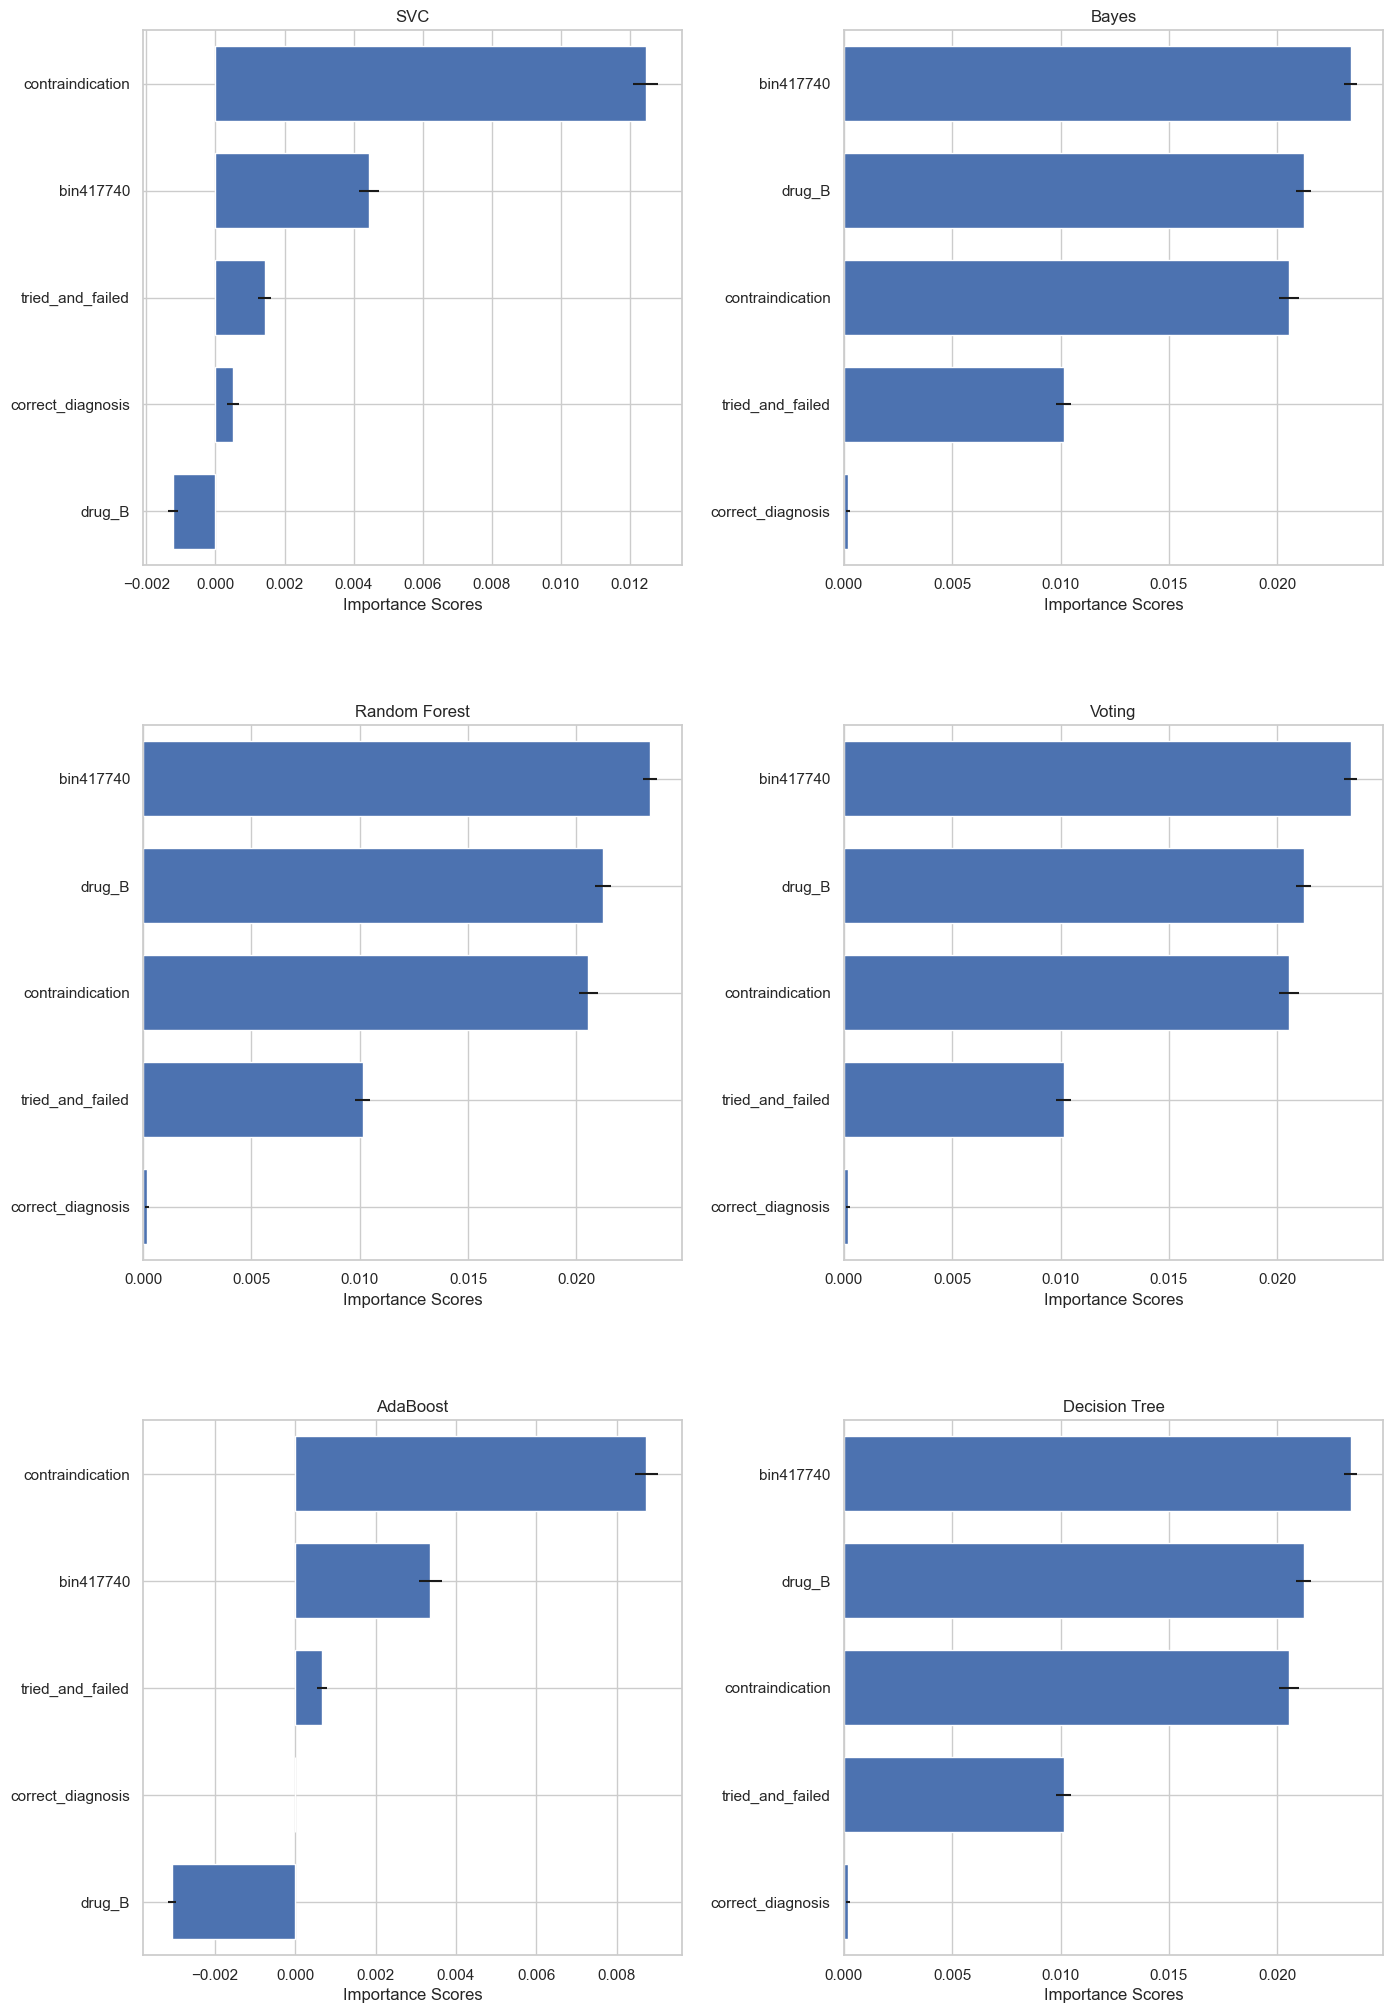

In [41]:
fig, axs = plt.subplots(3,2, figsize=(16,25))
indices = np.arange(0, len(heir_feats)) + 0.5
model_list=['SVC', 'Bayes', 'Random Forest', 'Voting','AdaBoost','Decision Tree', 'Logistic']
for j in range(0,2):
    for k in range(0,3):
        if 2*k+j==7: 
            fig.delaxes(axs[k,j])
        else:   
            model_name=model_list[2*k+j]
            importance_sorted_idx = np.argsort(heir_df_importances.loc[model_name])
            axs[k,j].barh(indices, np.array(heir_df_importances.loc[model_name][importance_sorted_idx]).ravel(),
                          xerr= np.array(2*heir_df_std_devs.loc[model_name][importance_sorted_idx]),
              height=0.7)
            axs[k,j].set_yticks(indices)
            new_order = [heir_feats[i] for i in importance_sorted_idx]
            axs[k,j].set_yticklabels(new_order)
            axs[k,j].set_ylim((0, len(heir_feats)))
            axs[k,j].set_xlabel('Importance Scores')
            axs[k,j].set_title(model_name)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

### Conclusion 
The support vector machine and AdaBoost assigned a negative importance to the drug type. This mean the f score of these models increased when this feature data was randomized. Since the type of drug should influence whether or not a PA is approved, we can conclude that these two models are not the best for our purposes. In order to distinguish between the other models, we refer to the drop-feature importance with ROC score. 